# NeMo Data Designer for Stroke Prediction Class Imbalance

Using NeMo Data Designer to generate synthetic stroke patients (minority class augmentation)

**⚠️ Important Workflow Note:**
- This notebook uses **UNSCALED** data (real ages, glucose levels, BMI) for NDD generation
- The LLM validation evaluates medical plausibility with actual values (age=67, not 0.72)
- After generation, we **scale** the synthetic samples using the same `RobustScaler` fitted during feature engineering
- Finally, we combine **scaled** synthetic + **scaled** original data for model training
- This ensures the LLM can meaningfully evaluate medical coherence while maintaining proper ML preprocessing


## 1. Setup and Load Packages


In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, roc_curve, precision_recall_curve
)
import xgboost as xgb

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load environment variables
load_dotenv()

print("All packages loaded successfully!")

All packages loaded successfully!


In [2]:
from nemo_microservices.data_designer.essentials import (
    CategorySamplerParams,
    DataDesignerConfigBuilder,
    LLMTextColumnConfig,
    NeMoDataDesignerClient,
    UniformSamplerParams,
    SamplerColumnConfig,
    SamplerType,
)

data_designer_client = NeMoDataDesignerClient(
    base_url="https://ai.api.nvidia.com/v1/nemo/dd",
    default_headers={"Authorization": f"Bearer {os.getenv('NVIDIA_API_KEY')}"}
)

model_alias = "nemotron-super"  

print(f"✓ NeMo Data Designer client initialized!")
print(f"✓ Using model: {model_alias}")

✓ NeMo Data Designer client initialized!
✓ Using model: nemotron-super


## 2. Load and Analyze Data

We need to understand the distributions of stroke patients to configure our NDD samplers


In [3]:
# Load UNSCALED data for NeMo Data Designer
# NDD needs real values (age in years, glucose in mg/dL, BMI) for LLM validation
df = pd.read_csv('../data/stroke_data_unscaled.csv')

print(f"📊 Dataset shape: {df.shape}")
print(f"\n📋 Features ({len(df.columns)} total):")
print(f"   {df.columns.tolist()}")
print(f"\n🔍 Using UNSCALED data for NDD (real ages, glucose, BMI)")
print(f"   This allows LLM to evaluate medical plausibility with actual values")
print(f"\n📈 Class distribution:")
print(df['stroke'].value_counts())
print(f"\n📊 Class distribution (%):")
print(df['stroke'].value_counts(normalize=True) * 100)

stroke_cases = df[df['stroke'] == 1]
non_stroke_cases = df[df['stroke'] == 0]

print(f"\n✓ Stroke cases: {len(stroke_cases)} ({len(stroke_cases)/len(df)*100:.2f}%)")
print(f"✓ Non-stroke cases: {len(non_stroke_cases)} ({len(non_stroke_cases)/len(df)*100:.2f}%)")

df.head()

📊 Dataset shape: (5110, 17)

📋 Features (17 total):
   ['id', 'age', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']

🔍 Using UNSCALED data for NDD (real ages, glucose, BMI)
   This allows LLM to evaluate medical plausibility with actual values

📈 Class distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

📊 Class distribution (%):
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

✓ Stroke cases: 249 (4.87%)
✓ Non-stroke cases: 4861 (95.13%)


,id,age,avg_glucose_level,bmi,stroke,gender_Male,hypertension_Yes,heart_disease_Yes,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,228.69,36.6,1,1,0,1,1,0,1,0,0,1,1,0,0
1,51676,61.0,202.21,28.1,1,0,0,0,1,0,0,1,0,0,0,1,0
2,31112,80.0,105.92,32.5,1,1,0,1,1,0,1,0,0,0,0,1,0
3,60182,49.0,171.23,34.4,1,0,0,0,1,0,1,0,0,1,0,0,1
4,1665,79.0,174.12,24.0,1,0,1,0,1,0,0,1,0,0,0,1,0


In [4]:
print("=" * 70)
print("Numerical Feature Statistics - STROKE PATIENTS (UNSCALED)")
print("=" * 70)
print(stroke_cases[['age', 'avg_glucose_level', 'bmi']].describe())
print("\nℹ️  These are REAL values:")
print("   - Age: in years")
print("   - Glucose: in mg/dL")
print("   - BMI: body mass index")

print("\n" + "=" * 70)
print("Numerical Feature Statistics - NON-STROKE PATIENTS (UNSCALED)")
print("=" * 70)
print(non_stroke_cases[['age', 'avg_glucose_level', 'bmi']].describe())

Numerical Feature Statistics - STROKE PATIENTS (UNSCALED)
              age  avg_glucose_level         bmi
count  249.000000         249.000000  249.000000
mean    67.728193         132.544739   30.090361
std     12.727419          61.921056    5.861877
min      1.320000          56.110000   16.900000
25%     59.000000          79.790000   27.000000
50%     71.000000         105.220000   28.100000
75%     78.000000         196.710000   32.500000
max     82.000000         271.740000   56.600000

ℹ️  These are REAL values:
   - Age: in years
   - Glucose: in mg/dL
   - BMI: body mass index

Numerical Feature Statistics - NON-STROKE PATIENTS (UNSCALED)
               age  avg_glucose_level          bmi
count  4861.000000        4861.000000  4861.000000
mean     41.971545         104.795513    28.799115
std      22.291940          43.846069     7.777269
min       0.080000          55.120000    10.300000
25%      24.000000          77.120000    23.600000
50%      43.000000          91.47000

### Categorical Feature Distributions for Stroke Patients


In [5]:
# Analyze categorical feature distributions for stroke patients
binary_features = ['gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 
                    'ever_married_Yes', 'Residence_type_Urban']

print("Binary Feature Distributions (Stroke Patients):")
print("=" * 70)
for feature in binary_features:
    dist = stroke_cases[feature].value_counts(normalize=True)
    print(f"\n{feature}:")
    print(f"  0: {dist.get(0, 0):.2%}")
    print(f"  1: {dist.get(1, 0):.2%}")

print("\n" + "=" * 70)
print("Work Type Distribution (Stroke Patients):")
print("=" * 70)
work_cols = ['work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children']
for col in work_cols:
    pct = stroke_cases[col].sum() / len(stroke_cases)
    print(f"  {col}: {pct:.2%}")

print("\n" + "=" * 70)
print("Smoking Status Distribution (Stroke Patients):")
print("=" * 70)
smoking_cols = ['smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']
for col in smoking_cols:
    pct = stroke_cases[col].sum() / len(stroke_cases)
    print(f"  {col}: {pct:.2%}")

Binary Feature Distributions (Stroke Patients):

gender_Male:
  0: 56.63%
  1: 43.37%

hypertension_Yes:
  0: 73.49%
  1: 26.51%

heart_disease_Yes:
  0: 81.12%
  1: 18.88%

ever_married_Yes:
  0: 11.65%
  1: 88.35%

Residence_type_Urban:
  0: 45.78%
  1: 54.22%

Work Type Distribution (Stroke Patients):
  work_type_Never_worked: 0.00%
  work_type_Private: 59.84%
  work_type_Self-employed: 26.10%
  work_type_children: 0.80%

Smoking Status Distribution (Stroke Patients):
  smoking_status_formerly smoked: 28.11%
  smoking_status_never smoked: 36.14%
  smoking_status_smokes: 16.87%


## 3. Configure NeMo Data Designer

Now we'll configure NDD samplers based on the stroke patient distributions we just analyzed

### Step 1: Initialize Config Builder and Configure Numerical Features


In [6]:
# Initialize configuration builder
config_builder = DataDesignerConfigBuilder()

print("⚙️  Configuring NDD samplers for synthetic stroke patients...")
print("\n1️⃣ Adding numerical features (UNSCALED - real values)...")

# Add Age (unscaled - in years)
age_min = float(stroke_cases['age'].min())
age_max = float(stroke_cases['age'].max())
config_builder.add_column(
    SamplerColumnConfig(
        name="age",
        sampler_type=SamplerType.UNIFORM,
        params=UniformSamplerParams(low=age_min, high=age_max),
    )
)
print(f"   Age: {age_min:.1f} - {age_max:.1f} years")

# Add Average Glucose Level (unscaled - in mg/dL)
glucose_min = float(stroke_cases['avg_glucose_level'].min())
glucose_max = float(stroke_cases['avg_glucose_level'].max())
config_builder.add_column(
    SamplerColumnConfig(
        name="avg_glucose_level",
        sampler_type=SamplerType.UNIFORM,
        params=UniformSamplerParams(low=glucose_min, high=glucose_max),
    )
)
print(f"   Glucose: {glucose_min:.1f} - {glucose_max:.1f} mg/dL")

# Add BMI (unscaled - body mass index)
bmi_min = float(stroke_cases['bmi'].min())
bmi_max = float(stroke_cases['bmi'].max())
config_builder.add_column(
    SamplerColumnConfig(
        name="bmi",
        sampler_type=SamplerType.UNIFORM,
        params=UniformSamplerParams(low=bmi_min, high=bmi_max),
    )
)
print(f"   BMI: {bmi_min:.1f} - {bmi_max:.1f}")

print("\n✓ Numerical features configured with REAL VALUES")

⚙️  Configuring NDD samplers for synthetic stroke patients...

1️⃣ Adding numerical features (UNSCALED - real values)...
   Age: 1.3 - 82.0 years
   Glucose: 56.1 - 271.7 mg/dL
   BMI: 16.9 - 56.6

✓ Numerical features configured with REAL VALUES


### Step 2: Configure Binary Categorical Features

In [7]:
print("2️⃣ Adding binary categorical features...")

binary_features = ['gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 
                    'ever_married_Yes', 'Residence_type_Urban']

for feature in binary_features:
    dist = stroke_cases[feature].value_counts(normalize=True).to_dict()
    config_builder.add_column(
        SamplerColumnConfig(
            name=feature,
            sampler_type=SamplerType.CATEGORY,
            params=CategorySamplerParams(
                values=[0, 1],
                weights=[dist.get(0, 0.5), dist.get(1, 0.5)]
            ),
            convert_to="int"
        )
    )
    
print(f"✓ Configured {len(binary_features)} binary features")


2️⃣ Adding binary categorical features...
✓ Configured 5 binary features


### Step 3: Configure Multi-Class Categorical Features (Work Type & Smoking Status)

In [8]:
print("3️⃣ Adding multi-class categorical features...")

# Work Type
work_types = ["Never_worked", "Private", "Self-employed", "children"]
work_weights = [
    stroke_cases['work_type_Never_worked'].sum() / len(stroke_cases),
    stroke_cases['work_type_Private'].sum() / len(stroke_cases),
    stroke_cases['work_type_Self-employed'].sum() / len(stroke_cases),
    stroke_cases['work_type_children'].sum() / len(stroke_cases),
]

config_builder.add_column(
    SamplerColumnConfig(
        name="work_type",
        sampler_type=SamplerType.CATEGORY,
        params=CategorySamplerParams(
            values=work_types,
            weights=work_weights
        ),
    )
)

# Smoking Status
smoking_statuses = ["formerly smoked", "never smoked", "smokes"]
smoking_weights = [
    stroke_cases['smoking_status_formerly smoked'].sum() / len(stroke_cases),
    stroke_cases['smoking_status_never smoked'].sum() / len(stroke_cases),
    stroke_cases['smoking_status_smokes'].sum() / len(stroke_cases),
]

config_builder.add_column(
    SamplerColumnConfig(
        name="smoking_status",
        sampler_type=SamplerType.CATEGORY,
        params=CategorySamplerParams(
            values=smoking_statuses,
            weights=smoking_weights
        ),
    )
)

print("✓ Work type and smoking status configured")

3️⃣ Adding multi-class categorical features...
✓ Work type and smoking status configured


### Step 4: (Optional) Add LLM Medical Coherence Validation

This is NDD's unique strength - using an LLM to ensure feature combinations make medical sense


In [9]:
# Set to True to enable LLM-based medical coherence check (slower, more expensive, but validates data quality)
use_llm_validation = True  # Change to False to skip

if use_llm_validation:
    print("4️⃣ Adding LLM medical coherence validation...")
    
    config_builder.add_column(
        LLMTextColumnConfig(
            name="medical_plausibility",
            prompt=(
                "Given a stroke patient with:\\n"
                "- Age: {{ age }} years\\n"
                "- Average glucose level: {{ avg_glucose_level }} mg/dL\\n"
                "- BMI: {{ bmi }}\\n"
                "- Hypertension: {{ hypertension_Yes }} (0=No, 1=Yes)\\n"
                "- Heart disease: {{ heart_disease_Yes }} (0=No, 1=Yes)\\n"
                "- Smoking status: {{ smoking_status }}\\n\\n"
                "Rate the medical plausibility of this combination (1-10). "
                "Higher scores mean more realistic/typical stroke patient profile. "
                "Consider how these risk factors commonly occur together in actual stroke patients. "
                "Respond with ONLY a number from 1 to 10."
            ),
            system_prompt=(
                "You are a medical expert evaluating stroke patient profiles. "
                "Consider realistic medical scenarios and how risk factors "
                "(age, glucose, BMI, hypertension, heart disease, smoking) "
                "typically present together in actual stroke patients."
            ),
            model_alias=model_alias,
        )
    )
    
    print("✓ LLM validation configured - will generate plausibility scores (1-10)")
    print("   LLM will see ACTUAL medical values (age in years, glucose in mg/dL, etc.)")
else:
    print("4️⃣ Skipping LLM validation")

print("\n✅ Configuration complete!")


4️⃣ Adding LLM medical coherence validation...
✓ LLM validation configured - will generate plausibility scores (1-10)
   LLM will see ACTUAL medical values (age in years, glucose in mg/dL, etc.)

✅ Configuration complete!


In [10]:
def extract_plausibility_score(text):
    """
    Extract numeric plausibility score (1-10) from LLM response
    Handles responses with <think> tags and explanations
    
    The LLM may include its thinking process in <think>...</think> tags,
    followed by the final numeric score. This function extracts just the number.
    
    Args:
        text: Raw LLM response text
        
    Returns:
        Numeric score (1-10) or NaN if extraction fails
    """
    if pd.isna(text):
        return np.nan
    
    text = str(text).strip()
    
    # Remove <think>...</think> tags and their content
    text_cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
    
    # Find all numbers in the remaining text (after removing think tags)
    numbers = re.findall(r'\b([1-9]|10)\b', text_cleaned)
    
    if numbers:
        # Return the first valid number found (should be the final answer)
        return int(numbers[0])
    
    # Fallback: try to find any number (1-10) in original text
    numbers = re.findall(r'\b([1-9]|10)\b', text)
    if numbers:
        return int(numbers[0])
    
    return np.nan

## 4. Generate Preview (Test Configuration)

First, generate a small preview to verify everything works correctly


In [11]:
print("🔍 Generating preview (10 synthetic stroke patients)...")
print("⏱️  This may take 1-2 minutes...\n")

preview = data_designer_client.preview(config_builder, num_records=10)

print("\n✓ Preview generated successfully!")


[09:43:47] [INFO] ✅ Validation passed
[09:43:47] [INFO] 🚀 Starting preview generation


🔍 Generating preview (10 synthetic stroke patients)...
⏱️  This may take 1-2 minutes...



[09:43:48] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[09:43:48] [INFO] 🩺 Running health checks for models...
[09:43:50] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[09:43:50] [INFO]   |-- ✅ Passed!
[09:43:52] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[09:43:52] [INFO]   |-- ✅ Passed!
[09:43:53] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[09:43:53] [INFO]   |-- ✅ Passed!
[09:43:53] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[09:43:53] [INFO]   |-- ✅ Passed!
[09:43:54] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[09:43:54] [INFO]   |-- ✅ Passed!
[09:43:56] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[09:43:56] [INFO]   |-- ✅ Passed!
[09:43:56] [INFO] ⏳ Processing batch 1 of 1
[09:43:56] [INFO] 🎲 Preparing samplers to generate 10 records across 10 columns
[09:43:56] [INFO] 📝 Preparing llm-text column generation
[09:43:56] [INFO]   |-- column name: 'medical_plausibility


✓ Preview generated successfully!


In [12]:
preview.display_sample_record()

                                                 Generated Columns                                                 
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                 ┃ Value                                                                                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ age                  │ 33.40492916233599                                                                        │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ avg_glucose_level    │ 136.74689414737819                                                                       │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ bmi                  │ 49.66889751299906                                                                        │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ gender_Male          │ 0                                                                                        │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ hypertension_Yes     │ 0                                                                                        │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ heart_disease_Yes    │ 1                                                                                        │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ ever_married_Yes     │ 1                                                                                        │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ Residence_type_Urban │ 0                                                                                        │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ work_type            │ Self-employed                                                                            │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ smoking_status       │ never smoked                                                                             │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│ medical_plausibility │ <think>                                                                                  │
│                      │ Okay, let's tackle this. I need to rate the medical plausibility of a stroke patient     │
│                      │ with these specific risk factors. Let's go through each one step by step.                │
│                      │                                                                                          │
│                      │ First, the age is 33.4 years. That's pretty young for a stroke. Most strokes occur in    │
│                      │ older adults, typically over 65. However, younger people can have strokes too,           │
│                      │ especially if they have significant risk factors. So age alone might lower the           │
│                      │ plausibility a bit, but it's not impossible.                                             │
│                      │                                                                                          │
│                      │ Next, average glucose level is 136.7 mg/dL. Normal fasting glucose is under 100, so this │
│                      │ is in the impaired fasting gluc

In [13]:
preview_df = preview.dataset
print(f"Preview dataset shape: {preview_df.shape}")
print(f"\nPreview columns: {preview_df.columns.tolist()}")
preview_df['medical_plausibility'] = preview_df['medical_plausibility'].apply(extract_plausibility_score)
preview_df.head(n=10)

Preview dataset shape: (10, 11)

Preview columns: ['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes', 'Residence_type_Urban', 'work_type', 'smoking_status', 'medical_plausibility']


,age,avg_glucose_level,bmi,gender_Male,hypertension_Yes,heart_disease_Yes,ever_married_Yes,Residence_type_Urban,work_type,smoking_status,medical_plausibility
0,33.404929,136.746894,49.668898,0,0,1,1,0,Self-employed,never smoked,6
1,68.330115,72.373916,53.882753,1,0,0,1,1,Private,never smoked,5
2,18.509482,112.903970,37.014471,0,1,0,1,1,Private,never smoked,4
3,4.744309,101.849085,21.794158,0,1,1,1,1,Private,never smoked,2
4,72.671373,236.698290,55.450354,1,0,0,1,1,Private,never smoked,6
5,13.676567,158.298583,34.670138,1,0,0,0,1,Self-employed,never smoked,2
6,33.409735,107.133325,30.318640,0,0,0,1,0,Self-employed,formerly smoked,6
7,43.698219,76.239083,24.133159,1,0,0,0,0,Self-employed,never smoked,4
8,3.997033,61.516272,30.978018,0,0,0,1,1,Private,formerly smoked,1
9,32.710305,137.270569,51.113644,1,0,0,0,0,Self-employed,formerly smoked,4


## 5. Generate Full Synthetic Dataset

**⚠️ Important**: This step will take time (10-20 minutes) and consume API credits (~$0.50-2.00)

Choose your augmentation strategy:
- **Conservative** (2x minority): 249 samples (recommended for testing)
- **Moderate** (4x minority): 747 samples
- **Aggressive** (full balance): ~4,612 samples


In [17]:
# Calculate generation options
num_minority = len(stroke_cases)
num_majority = len(non_stroke_cases)

print(f"Original minority class size: {num_minority}")
print(f"Original majority class size: {num_majority}")
print(f"\nGeneration options:")
print(f"  Conservative (2x minority): {num_minority} samples")
print(f"  Moderate (4x minority): {num_minority * 3} samples")
print(f"  Aggressive (full balance): {num_majority - num_minority} samples")

num_to_generate = num_majority - num_minority

print(f"\n🎯 Will generate: {num_to_generate} synthetic stroke patients")
print(f"⚠️  Uncomment the cell below to run the generation")

Original minority class size: 249
Original majority class size: 4861

Generation options:
  Conservative (2x minority): 249 samples
  Moderate (4x minority): 747 samples
  Aggressive (full balance): 4612 samples

🎯 Will generate: 4612 synthetic stroke patients
⚠️  Uncomment the cell below to run the generation


In [18]:
# Note: The managed NVIDIA API only supports preview() for data generation
# The create() method requires a self-hosted NeMo Data Designer NIM deployment
# For production-scale generation (1000s+ samples), consider self-hosting
# For our use case (249 samples), preview() works perfectly!

print("ℹ️  Using preview() for generation (managed API limitation)")
print(f"   Creating {num_to_generate} synthetic stroke patients...")

ℹ️  Using preview() for generation (managed API limitation)
   Creating 4612 synthetic stroke patients...


In [ ]:
# Generate full synthetic dataset in batches
# Note: preview() has a 100 record limit, so we'll generate in batches
# ⚠️ This will take 10-20 minutes and consume API credits (~$0.50-2.00)
# 💾 Each batch is saved immediately to prevent data loss on timeout

import os
from pathlib import Path
import glob

# Setup batch directory
batch_dir = Path('../data/ndd_batches')
batch_dir.mkdir(exist_ok=True)

print(f"🏭 Generating {num_to_generate} synthetic stroke patients...")
print(f"ℹ️  Preview API limit: 100 records per request")
print(f"   Will generate in {(num_to_generate + 99) // 100} batch(es)")
print(f"💾 Each batch will be saved to: {batch_dir}")
print(f"⏱️  This will take several minutes. Please wait...\n")

# Check for existing batches
existing_batches = sorted(glob.glob(str(batch_dir / 'batch_*.csv')))
if existing_batches:
    print(f"📂 Found {len(existing_batches)} existing batch file(s)")
    print(f"   Will skip already-generated batches\n")

# Generate in batches of 100
batch_size = 100
total_batches = (num_to_generate + batch_size - 1) // batch_size

for i in range(0, num_to_generate, batch_size):
    batch_num = (i // batch_size) + 1
    records_in_batch = min(batch_size, num_to_generate - i)
    batch_file = batch_dir / f'batch_{batch_num:03d}.csv'
    
    # Skip if batch already exists
    if batch_file.exists():
        print(f"⏭️  Batch {batch_num}/{total_batches}: Already exists, skipping...")
        continue
    
    print(f"📦 Batch {batch_num}/{total_batches}: Generating {records_in_batch} samples...")
    
    try:
        batch_result = data_designer_client.preview(config_builder, num_records=records_in_batch)
        batch_df = batch_result.dataset
        
        # Save batch immediately
        batch_df.to_csv(batch_file, index=False)
        
        print(f"   ✓ Batch {batch_num} complete ({len(batch_df)} samples)")
        print(f"   💾 Saved to: {batch_file.name}")
    except Exception as e:
        print(f"   ❌ Batch {batch_num} failed: {e}")
        print(f"   💡 Already saved {batch_num - 1} batches. You can rerun to continue.")
        raise

# Load and combine all saved batches
print(f"\n📂 Loading all saved batches from {batch_dir}...")
all_batch_files = sorted(glob.glob(str(batch_dir / 'batch_*.csv')))
synthetic_batches = [pd.read_csv(f) for f in all_batch_files]
synthetic_df = pd.concat(synthetic_batches, ignore_index=True)

print(f"\n✅ Combined {len(all_batch_files)} batches into {len(synthetic_df)} synthetic samples!")
print(f"Synthetic dataset shape: {synthetic_df.shape}")

# Save the combined raw synthetic data (before processing)
synthetic_raw_path = '../data/ndd_synthetic_raw.csv'
synthetic_df.to_csv(synthetic_raw_path, index=False)
print(f"\n💾 Saved combined raw synthetic data to: {synthetic_raw_path}")
print(f"   You can reload this to skip regeneration!")
print(f"\n💡 Individual batches saved in: {batch_dir}")
print(f"   Delete this folder if you want to regenerate from scratch")

[15:07:34] [INFO] ✅ Validation passed
[15:07:34] [INFO] 🚀 Starting preview generation


🏭 Generating 4612 synthetic stroke patients...
ℹ️  Preview API limit: 100 records per request
   Will generate in 47 batch(es)
💾 Each batch will be saved to: ../data/ndd_batches
⏱️  This will take several minutes. Please wait...

📦 Batch 1/47: Generating 100 samples...


[15:07:35] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:07:35] [INFO] 🩺 Running health checks for models...
[15:07:37] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:07:37] [INFO]   |-- ✅ Passed!
[15:07:40] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:07:40] [INFO]   |-- ✅ Passed!
[15:07:41] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:07:41] [INFO]   |-- ✅ Passed!
[15:07:42] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:07:42] [INFO]   |-- ✅ Passed!
[15:07:44] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:07:44] [INFO]   |-- ✅ Passed!
[15:07:44] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:07:44] [INFO]   |-- ✅ Passed!
[15:07:44] [INFO] ⏳ Processing batch 1 of 1
[15:07:44] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:07:44] [INFO] 📝 Preparing llm-text column generation
[15:07:44] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 1 complete (100 samples)
   💾 Saved to: batch_001.csv
📦 Batch 2/47: Generating 100 samples...


[15:12:09] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:12:09] [INFO] 🩺 Running health checks for models...
[15:12:11] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:12:11] [INFO]   |-- ✅ Passed!
[15:12:12] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:12:12] [INFO]   |-- ✅ Passed!
[15:12:13] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:12:13] [INFO]   |-- ✅ Passed!
[15:12:15] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:12:15] [INFO]   |-- ✅ Passed!
[15:12:16] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:12:16] [INFO]   |-- ✅ Passed!
[15:12:16] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:12:16] [INFO]   |-- ✅ Passed!
[15:12:16] [INFO] ⏳ Processing batch 1 of 1
[15:12:17] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:12:17] [INFO] 📝 Preparing llm-text column generation
[15:12:17] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 2 complete (100 samples)
   💾 Saved to: batch_002.csv
📦 Batch 3/47: Generating 100 samples...


[15:16:30] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:16:30] [INFO] 🩺 Running health checks for models...
[15:16:32] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:16:32] [INFO]   |-- ✅ Passed!
[15:16:33] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:16:33] [INFO]   |-- ✅ Passed!
[15:16:34] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:16:34] [INFO]   |-- ✅ Passed!
[15:16:35] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:16:35] [INFO]   |-- ✅ Passed!
[15:16:37] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:16:37] [INFO]   |-- ✅ Passed!
[15:16:38] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:16:38] [INFO]   |-- ✅ Passed!
[15:16:38] [INFO] ⏳ Processing batch 1 of 1
[15:16:38] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:16:38] [INFO] 📝 Preparing llm-text column generation
[15:16:38] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 3 complete (100 samples)
   💾 Saved to: batch_003.csv
📦 Batch 4/47: Generating 100 samples...


[15:20:43] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:20:43] [INFO] 🩺 Running health checks for models...
[15:20:44] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:20:44] [INFO]   |-- ✅ Passed!
[15:20:46] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:20:46] [INFO]   |-- ✅ Passed!
[15:20:47] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:20:47] [INFO]   |-- ✅ Passed!
[15:20:48] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:20:48] [INFO]   |-- ✅ Passed!
[15:20:48] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:20:48] [INFO]   |-- ✅ Passed!
[15:20:49] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:20:49] [INFO]   |-- ✅ Passed!
[15:20:49] [INFO] ⏳ Processing batch 1 of 1
[15:20:49] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:20:49] [INFO] 📝 Preparing llm-text column generation
[15:20:49] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 4 complete (100 samples)
   💾 Saved to: batch_004.csv
📦 Batch 5/47: Generating 100 samples...


[15:25:07] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:25:07] [INFO] 🩺 Running health checks for models...
[15:25:09] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:25:09] [INFO]   |-- ✅ Passed!
[15:25:10] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:25:10] [INFO]   |-- ✅ Passed!
[15:25:11] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:25:11] [INFO]   |-- ✅ Passed!
[15:25:12] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:25:12] [INFO]   |-- ✅ Passed!
[15:25:13] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:25:13] [INFO]   |-- ✅ Passed!
[15:25:13] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:25:13] [INFO]   |-- ✅ Passed!
[15:25:13] [INFO] ⏳ Processing batch 1 of 1
[15:25:13] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:25:13] [INFO] 📝 Preparing llm-text column generation
[15:25:13] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 5 complete (100 samples)
   💾 Saved to: batch_005.csv
📦 Batch 6/47: Generating 100 samples...


[15:29:20] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:29:20] [INFO] 🩺 Running health checks for models...
[15:29:22] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:29:22] [INFO]   |-- ✅ Passed!
[15:29:24] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:29:24] [INFO]   |-- ✅ Passed!
[15:29:25] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:29:25] [INFO]   |-- ✅ Passed!
[15:29:26] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:29:26] [INFO]   |-- ✅ Passed!
[15:29:27] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:29:27] [INFO]   |-- ✅ Passed!
[15:29:28] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:29:28] [INFO]   |-- ✅ Passed!
[15:29:28] [INFO] ⏳ Processing batch 1 of 1
[15:29:28] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:29:28] [INFO] 📝 Preparing llm-text column generation
[15:29:28] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 6 complete (100 samples)
   💾 Saved to: batch_006.csv
📦 Batch 7/47: Generating 100 samples...


[15:33:44] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:33:44] [INFO] 🩺 Running health checks for models...
[15:33:45] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:33:45] [INFO]   |-- ✅ Passed!
[15:33:47] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:33:47] [INFO]   |-- ✅ Passed!
[15:33:48] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:33:48] [INFO]   |-- ✅ Passed!
[15:33:48] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:33:48] [INFO]   |-- ✅ Passed!
[15:33:50] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:33:50] [INFO]   |-- ✅ Passed!
[15:33:50] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:33:50] [INFO]   |-- ✅ Passed!
[15:33:50] [INFO] ⏳ Processing batch 1 of 1
[15:33:50] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:33:50] [INFO] 📝 Preparing llm-text column generation
[15:33:50] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 7 complete (100 samples)
   💾 Saved to: batch_007.csv
📦 Batch 8/47: Generating 100 samples...


[15:38:16] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:38:16] [INFO] 🩺 Running health checks for models...
[15:38:17] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:38:17] [INFO]   |-- ✅ Passed!
[15:38:19] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:38:19] [INFO]   |-- ✅ Passed!
[15:38:20] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:38:20] [INFO]   |-- ✅ Passed!
[15:38:21] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:38:21] [INFO]   |-- ✅ Passed!
[15:38:22] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:38:22] [INFO]   |-- ✅ Passed!
[15:38:23] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:38:23] [INFO]   |-- ✅ Passed!
[15:38:23] [INFO] ⏳ Processing batch 1 of 1
[15:38:23] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:38:23] [INFO] 📝 Preparing llm-text column generation
[15:38:23] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 8 complete (100 samples)
   💾 Saved to: batch_008.csv
📦 Batch 9/47: Generating 100 samples...


[15:42:43] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:42:43] [INFO] 🩺 Running health checks for models...
[15:42:45] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:42:45] [INFO]   |-- ✅ Passed!
[15:42:47] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:42:47] [INFO]   |-- ✅ Passed!
[15:42:48] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:42:48] [INFO]   |-- ✅ Passed!
[15:42:48] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:42:48] [INFO]   |-- ✅ Passed!
[15:42:49] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:42:49] [INFO]   |-- ✅ Passed!
[15:42:50] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:42:50] [INFO]   |-- ✅ Passed!
[15:42:50] [INFO] ⏳ Processing batch 1 of 1
[15:42:50] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:42:50] [INFO] 📝 Preparing llm-text column generation
[15:42:50] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 9 complete (100 samples)
   💾 Saved to: batch_009.csv
📦 Batch 10/47: Generating 100 samples...


[15:47:09] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:47:09] [INFO] 🩺 Running health checks for models...
[15:47:10] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:47:10] [INFO]   |-- ✅ Passed!
[15:47:12] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:47:12] [INFO]   |-- ✅ Passed!
[15:47:13] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:47:13] [INFO]   |-- ✅ Passed!
[15:47:14] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:47:14] [INFO]   |-- ✅ Passed!
[15:47:15] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:47:15] [INFO]   |-- ✅ Passed!
[15:47:15] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:47:15] [INFO]   |-- ✅ Passed!
[15:47:15] [INFO] ⏳ Processing batch 1 of 1
[15:47:15] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:47:15] [INFO] 📝 Preparing llm-text column generation
[15:47:15] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 10 complete (100 samples)
   💾 Saved to: batch_010.csv
📦 Batch 11/47: Generating 100 samples...


[15:51:35] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:51:35] [INFO] 🩺 Running health checks for models...
[15:51:37] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:51:37] [INFO]   |-- ✅ Passed!
[15:51:39] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:51:39] [INFO]   |-- ✅ Passed!
[15:51:40] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:51:40] [INFO]   |-- ✅ Passed!
[15:51:41] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:51:41] [INFO]   |-- ✅ Passed!
[15:51:42] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:51:42] [INFO]   |-- ✅ Passed!
[15:51:43] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:51:43] [INFO]   |-- ✅ Passed!
[15:51:43] [INFO] ⏳ Processing batch 1 of 1
[15:51:43] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:51:43] [INFO] 📝 Preparing llm-text column generation
[15:51:43] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 11 complete (100 samples)
   💾 Saved to: batch_011.csv
📦 Batch 12/47: Generating 100 samples...


[15:55:59] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[15:55:59] [INFO] 🩺 Running health checks for models...
[15:56:00] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[15:56:00] [INFO]   |-- ✅ Passed!
[15:56:02] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[15:56:02] [INFO]   |-- ✅ Passed!
[15:56:03] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[15:56:03] [INFO]   |-- ✅ Passed!
[15:56:04] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[15:56:04] [INFO]   |-- ✅ Passed!
[15:56:04] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[15:56:04] [INFO]   |-- ✅ Passed!
[15:56:05] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[15:56:05] [INFO]   |-- ✅ Passed!
[15:56:05] [INFO] ⏳ Processing batch 1 of 1
[15:56:05] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[15:56:05] [INFO] 📝 Preparing llm-text column generation
[15:56:05] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 12 complete (100 samples)
   💾 Saved to: batch_012.csv
📦 Batch 13/47: Generating 100 samples...


[16:00:34] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:00:34] [INFO] 🩺 Running health checks for models...
[16:00:35] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:00:35] [INFO]   |-- ✅ Passed!
[16:00:37] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:00:37] [INFO]   |-- ✅ Passed!
[16:00:38] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:00:38] [INFO]   |-- ✅ Passed!
[16:00:38] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:00:38] [INFO]   |-- ✅ Passed!
[16:00:39] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:00:39] [INFO]   |-- ✅ Passed!
[16:00:40] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:00:40] [INFO]   |-- ✅ Passed!
[16:00:40] [INFO] ⏳ Processing batch 1 of 1
[16:00:40] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:00:40] [INFO] 📝 Preparing llm-text column generation
[16:00:40] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 13 complete (100 samples)
   💾 Saved to: batch_013.csv
📦 Batch 14/47: Generating 100 samples...


[16:04:57] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:04:57] [INFO] 🩺 Running health checks for models...
[16:05:00] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:05:00] [INFO]   |-- ✅ Passed!
[16:05:01] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:05:01] [INFO]   |-- ✅ Passed!
[16:05:02] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:05:02] [INFO]   |-- ✅ Passed!
[16:05:03] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:05:03] [INFO]   |-- ✅ Passed!
[16:05:03] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:05:03] [INFO]   |-- ✅ Passed!
[16:05:05] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:05:05] [INFO]   |-- ✅ Passed!
[16:05:05] [INFO] ⏳ Processing batch 1 of 1
[16:05:05] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:05:05] [INFO] 📝 Preparing llm-text column generation
[16:05:05] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 14 complete (100 samples)
   💾 Saved to: batch_014.csv
📦 Batch 15/47: Generating 100 samples...


[16:09:17] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:09:17] [INFO] 🩺 Running health checks for models...
[16:09:19] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:09:19] [INFO]   |-- ✅ Passed!
[16:09:21] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:09:21] [INFO]   |-- ✅ Passed!
[16:09:22] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:09:22] [INFO]   |-- ✅ Passed!
[16:09:22] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:09:22] [INFO]   |-- ✅ Passed!
[16:09:24] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:09:24] [INFO]   |-- ✅ Passed!
[16:09:25] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:09:25] [INFO]   |-- ✅ Passed!
[16:09:25] [INFO] ⏳ Processing batch 1 of 1
[16:09:25] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:09:25] [INFO] 📝 Preparing llm-text column generation
[16:09:25] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 15 complete (100 samples)
   💾 Saved to: batch_015.csv
📦 Batch 16/47: Generating 100 samples...


[16:13:40] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:13:40] [INFO] 🩺 Running health checks for models...
[16:13:42] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:13:42] [INFO]   |-- ✅ Passed!
[16:13:44] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:13:44] [INFO]   |-- ✅ Passed!
[16:13:45] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:13:45] [INFO]   |-- ✅ Passed!
[16:13:45] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:13:45] [INFO]   |-- ✅ Passed!
[16:13:47] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:13:47] [INFO]   |-- ✅ Passed!
[16:13:47] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:13:47] [INFO]   |-- ✅ Passed!
[16:13:47] [INFO] ⏳ Processing batch 1 of 1
[16:13:48] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:13:48] [INFO] 📝 Preparing llm-text column generation
[16:13:48] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 16 complete (100 samples)
   💾 Saved to: batch_016.csv
📦 Batch 17/47: Generating 100 samples...


[16:18:05] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:18:05] [INFO] 🩺 Running health checks for models...
[16:18:07] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:18:07] [INFO]   |-- ✅ Passed!
[16:18:08] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:18:08] [INFO]   |-- ✅ Passed!
[16:18:09] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:18:09] [INFO]   |-- ✅ Passed!
[16:18:10] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:18:10] [INFO]   |-- ✅ Passed!
[16:18:13] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:18:13] [INFO]   |-- ✅ Passed!
[16:18:13] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:18:13] [INFO]   |-- ✅ Passed!
[16:18:13] [INFO] ⏳ Processing batch 1 of 1
[16:18:13] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:18:13] [INFO] 📝 Preparing llm-text column generation
[16:18:13] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 17 complete (100 samples)
   💾 Saved to: batch_017.csv
📦 Batch 18/47: Generating 100 samples...


[16:22:30] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:22:30] [INFO] 🩺 Running health checks for models...
[16:22:32] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:22:32] [INFO]   |-- ✅ Passed!
[16:22:34] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:22:34] [INFO]   |-- ✅ Passed!
[16:22:35] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:22:35] [INFO]   |-- ✅ Passed!
[16:22:35] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:22:35] [INFO]   |-- ✅ Passed!
[16:22:37] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:22:37] [INFO]   |-- ✅ Passed!
[16:22:38] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:22:38] [INFO]   |-- ✅ Passed!
[16:22:38] [INFO] ⏳ Processing batch 1 of 1
[16:22:38] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:22:38] [INFO] 📝 Preparing llm-text column generation
[16:22:38] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 18 complete (100 samples)
   💾 Saved to: batch_018.csv
📦 Batch 19/47: Generating 100 samples...


[16:26:55] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:26:55] [INFO] 🩺 Running health checks for models...
[16:26:57] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:26:57] [INFO]   |-- ✅ Passed!
[16:26:57] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:26:57] [INFO]   |-- ✅ Passed!
[16:26:58] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:26:58] [INFO]   |-- ✅ Passed!
[16:26:59] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:26:59] [INFO]   |-- ✅ Passed!
[16:27:04] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:29:05] [INFO]   |-- ✅ Passed!
[16:29:06] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:29:06] [INFO]   |-- ✅ Passed!
[16:29:06] [INFO] ⏳ Processing batch 1 of 1
[16:29:06] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:29:06] [INFO] 📝 Preparing llm-text column generation
[16:29:06] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 19 complete (100 samples)
   💾 Saved to: batch_019.csv
📦 Batch 20/47: Generating 100 samples...


[16:33:28] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:33:28] [INFO] 🩺 Running health checks for models...
[16:33:29] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:33:29] [INFO]   |-- ✅ Passed!
[16:33:30] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:33:30] [INFO]   |-- ✅ Passed!
[16:33:32] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:33:32] [INFO]   |-- ✅ Passed!
[16:33:32] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:33:32] [INFO]   |-- ✅ Passed!
[16:33:33] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:33:33] [INFO]   |-- ✅ Passed!
[16:33:34] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:33:34] [INFO]   |-- ✅ Passed!
[16:33:34] [INFO] ⏳ Processing batch 1 of 1
[16:33:34] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:33:34] [INFO] 📝 Preparing llm-text column generation
[16:33:34] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 20 complete (100 samples)
   💾 Saved to: batch_020.csv
📦 Batch 21/47: Generating 100 samples...


[16:37:52] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:37:52] [INFO] 🩺 Running health checks for models...
[16:37:53] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:37:53] [INFO]   |-- ✅ Passed!
[16:37:55] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:37:55] [INFO]   |-- ✅ Passed!
[16:37:56] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:37:56] [INFO]   |-- ✅ Passed!
[16:37:56] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:37:56] [INFO]   |-- ✅ Passed!
[16:37:57] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:37:57] [INFO]   |-- ✅ Passed!
[16:37:58] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:37:58] [INFO]   |-- ✅ Passed!
[16:37:58] [INFO] ⏳ Processing batch 1 of 1
[16:37:58] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:37:58] [INFO] 📝 Preparing llm-text column generation
[16:37:58] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 21 complete (100 samples)
   💾 Saved to: batch_021.csv
📦 Batch 22/47: Generating 100 samples...


[16:42:33] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:42:33] [INFO] 🩺 Running health checks for models...
[16:42:35] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:42:35] [INFO]   |-- ✅ Passed!
[16:42:36] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:42:36] [INFO]   |-- ✅ Passed!
[16:42:37] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:42:37] [INFO]   |-- ✅ Passed!
[16:42:38] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:42:38] [INFO]   |-- ✅ Passed!
[16:42:39] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:42:39] [INFO]   |-- ✅ Passed!
[16:42:40] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:42:40] [INFO]   |-- ✅ Passed!
[16:42:40] [INFO] ⏳ Processing batch 1 of 1
[16:42:40] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:42:40] [INFO] 📝 Preparing llm-text column generation
[16:42:40] [INFO]   |-- column name: 'medical_plausibilit

   ✓ Batch 22 complete (100 samples)
   💾 Saved to: batch_022.csv
📦 Batch 23/47: Generating 100 samples...


[16:47:00] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph
[16:47:00] [INFO] 🩺 Running health checks for models...
[16:47:02] [INFO]   |-- 👀 Checking 'nvidia/nvidia-nemotron-nano-9b-v2'...
[16:47:02] [INFO]   |-- ✅ Passed!
[16:47:03] [INFO]   |-- 👀 Checking 'nvidia/llama-3.3-nemotron-super-49b-v1.5'...
[16:47:03] [INFO]   |-- ✅ Passed!
[16:47:04] [INFO]   |-- 👀 Checking 'mistralai/mistral-small-24b-instruct'...
[16:47:04] [INFO]   |-- ✅ Passed!
[16:47:05] [INFO]   |-- 👀 Checking 'openai/gpt-oss-20b'...
[16:47:05] [INFO]   |-- ✅ Passed!
[16:47:06] [INFO]   |-- 👀 Checking 'openai/gpt-oss-120b'...
[16:47:06] [INFO]   |-- ✅ Passed!
[16:47:07] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct'...
[16:47:07] [INFO]   |-- ✅ Passed!
[16:47:07] [INFO] ⏳ Processing batch 1 of 1
[16:47:07] [INFO] 🎲 Preparing samplers to generate 100 records across 10 columns
[16:47:07] [INFO] 📝 Preparing llm-text column generation
[16:47:07] [INFO]   |-- column name: 'medical_plausibilit

## 6. (Optional) Load Previously Generated Data

If you've already generated synthetic data and saved it, you can load it to skip regeneration:

```python
# Option 1: Load the combined file (if generation completed successfully)
synthetic_df = pd.read_csv('../data/ndd_synthetic_raw.csv')
print(f"✅ Loaded {len(synthetic_df)} samples from combined file")
print(f"   Skipped regeneration (saved ~11 minutes and $0.50-2.00!)")

# Option 2: Load from individual batches (if generation was interrupted)
import glob
from pathlib import Path

batch_dir = Path('../data/ndd_batches')
batch_files = sorted(glob.glob(str(batch_dir / 'batch_*.csv')))
if batch_files:
    synthetic_batches = [pd.read_csv(f) for f in batch_files]
    synthetic_df = pd.concat(synthetic_batches, ignore_index=True)
    print(f"✅ Loaded {len(batch_files)} batches with {len(synthetic_df)} total samples")
    
    # Save combined file for easier loading next time
    synthetic_df.to_csv('../data/ndd_synthetic_raw.csv', index=False)
    print(f"💾 Saved combined file to: ../data/ndd_synthetic_raw.csv")
else:
    print("❌ No batch files found. Run the generation cell above.")
```


In [35]:
import joblib

# Load the fitted scaler from feature engineering
scaler_path = '../data/robust_scaler.pkl'
robust_scaler = joblib.load(scaler_path)

print(f"✓ Loaded RobustScaler from: {scaler_path}")
print(f"   This scaler will be applied to numerical features in synthetic data")
print(f"   to ensure consistency with the training data")


✓ Loaded RobustScaler from: ../data/robust_scaler.pkl
   This scaler will be applied to numerical features in synthetic data
   to ensure consistency with the training data


## 7. Load Scaler for Synthetic Data

We need to scale the synthetic data using the same scaler fitted on the original training data

Convert NDD output to match original dataset format and **scale numerical features**


## 8. Process Generated Data

Apply the same preprocessing and filtering to the synthetic data. This will also save the processed data to CSV.


In [52]:
def process_generated_data(generated_df, scaler, min_plausibility=None):
    """
    Convert generated data to match original dataset format and scale numerical features
    
    Args:
        generated_df: DataFrame from NDD (with UNSCALED numerical features)
        scaler: Fitted RobustScaler to apply to numerical features
        min_plausibility: Minimum plausibility score to keep (if using LLM validation)
    """
    print("🔄 Processing generated data...")
    
    # Filter by plausibility if specified
    if min_plausibility is not None and 'medical_plausibility' in generated_df.columns:
        original_len = len(generated_df)
        # Extract just the numeric value from the plausibility column
        # (handles LLM responses with <think> tags and explanations)
        generated_df['plausibility_score'] = generated_df['medical_plausibility'].apply(
            extract_plausibility_score
        )
        generated_df = generated_df[
            generated_df['plausibility_score'] >= min_plausibility
        ]
        print(f"   ✓ Extracted plausibility scores (1-10) from LLM responses")
        print(f"   Filtered by plausibility ≥{min_plausibility}: {original_len} → {len(generated_df)}")
    
    processed = pd.DataFrame()
    
    # Numerical features (UNSCALED from NDD)
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    processed[numerical_features] = generated_df[numerical_features].copy()
    
    print(f"   📊 Before scaling: age range [{processed['age'].min():.1f}, {processed['age'].max():.1f}]")
    
    # Apply the fitted scaler to numerical features
    processed[numerical_features] = scaler.transform(processed[numerical_features])
    
    print(f"   ✓ Scaled numerical features using fitted RobustScaler")
    print(f"   📊 After scaling: age range [{processed['age'].min():.3f}, {processed['age'].max():.3f}]")
    
    # Binary features
    processed['gender_Male'] = generated_df['gender_Male'].astype(int)
    processed['hypertension_Yes'] = generated_df['hypertension_Yes'].astype(int)
    processed['heart_disease_Yes'] = generated_df['heart_disease_Yes'].astype(int)
    processed['ever_married_Yes'] = generated_df['ever_married_Yes'].astype(int)
    processed['Residence_type_Urban'] = generated_df['Residence_type_Urban'].astype(int)
    
    # One-hot encode work_type
    processed['work_type_Never_worked'] = (generated_df['work_type'] == 'Never_worked').astype(int)
    processed['work_type_Private'] = (generated_df['work_type'] == 'Private').astype(int)
    processed['work_type_Self-employed'] = (generated_df['work_type'] == 'Self-employed').astype(int)
    processed['work_type_children'] = (generated_df['work_type'] == 'children').astype(int)
    
    # One-hot encode smoking_status
    processed['smoking_status_formerly smoked'] = (generated_df['smoking_status'] == 'formerly smoked').astype(int)
    processed['smoking_status_never smoked'] = (generated_df['smoking_status'] == 'never smoked').astype(int)
    processed['smoking_status_smokes'] = (generated_df['smoking_status'] == 'smokes').astype(int)
    
    # Add stroke label (all synthetic samples are stroke cases)
    processed['stroke'] = 1
    
    print(f"   ✓ Processed and scaled {len(processed)} samples")
    return processed

# Test with preview data
processed_preview = process_generated_data(
    preview_df, 
    scaler=robust_scaler,
    min_plausibility=7 if use_llm_validation else None
)
print(f"\nProcessed preview shape: {processed_preview.shape}")
print(f"Processed columns ({len(processed_preview.columns)}): {processed_preview.columns.tolist()}")
processed_preview.head()


🔄 Processing generated data...
   ✓ Extracted plausibility scores (1-10) from LLM responses
   Filtered by plausibility ≥7: 10 → 6
   📊 Before scaling: age range [37.8, 69.1]
   ✓ Scaled numerical features using fitted RobustScaler
   📊 After scaling: age range [-0.201, 0.669]
   ✓ Processed and scaled 6 samples

Processed preview shape: (6, 16)
Processed columns (16): ['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes', 'Residence_type_Urban', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'stroke']


,age,avg_glucose_level,bmi,gender_Male,hypertension_Yes,heart_disease_Yes,ever_married_Yes,Residence_type_Urban,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
1,-0.143650,4.019849,1.678258,0,0,1,1,0,0,1,0,0,1,0,0,1
5,-0.196867,3.649925,0.300022,0,0,0,1,0,0,1,0,0,0,0,1,1
6,0.668905,4.855757,1.820808,0,0,0,1,1,0,0,1,0,1,0,0,1
7,0.032266,4.283676,-1.198250,0,0,1,1,0,0,0,1,0,0,0,1,1
8,-0.200945,4.842059,1.649355,0,1,0,1,1,0,1,0,0,0,1,0,1


In [ ]:
# Ensure synthetic_df is available (load from batches or combined file if needed)
import glob
from pathlib import Path

if 'synthetic_df' not in locals():
    print("⚠️  synthetic_df not found in memory. Loading from saved files...")
    
    # Try loading the combined file first
    synthetic_raw_path = Path('../data/ndd_synthetic_raw.csv')
    if synthetic_raw_path.exists():
        synthetic_df = pd.read_csv(synthetic_raw_path)
        print(f"✅ Loaded {len(synthetic_df)} samples from: {synthetic_raw_path}")
    else:
        # Fall back to loading from batch files
        batch_dir = Path('../data/ndd_batches')
        batch_files = sorted(glob.glob(str(batch_dir / 'batch_*.csv')))
        
        if batch_files:
            print(f"📂 Loading {len(batch_files)} batch files...")
            synthetic_batches = [pd.read_csv(f) for f in batch_files]
            synthetic_df = pd.concat(synthetic_batches, ignore_index=True)
            print(f"✅ Loaded {len(synthetic_df)} samples from {len(batch_files)} batches")
            
            # Save combined file for easier loading next time
            synthetic_df.to_csv(synthetic_raw_path, index=False)
            print(f"💾 Saved combined file to: {synthetic_raw_path}")
        else:
            raise FileNotFoundError(
                "❌ No synthetic data found!\n"
                "   Please run the generation cell (cell 27) first, or check your data directory."
            )
else:
    print(f"✓ synthetic_df already in memory ({len(synthetic_df)} samples)")


In [ ]:
# Process the full synthetic dataset
processed_synthetic = process_generated_data(
    synthetic_df,
    scaler=robust_scaler,
    min_plausibility=7 if use_llm_validation else None
)
print(f"Final processed synthetic data shape: {processed_synthetic.shape}")

# Save the processed synthetic data
processed_path = '../data/ndd_synthetic_processed.csv'
processed_synthetic.to_csv(processed_path, index=False)
print(f"\n💾 Saved processed synthetic data to: {processed_path}")


🔄 Processing generated data...
   ✓ Extracted plausibility scores (1-10) from LLM responses
   Filtered by plausibility ≥7: 249 → 87
   📊 Before scaling: age range [24.6, 81.2]
   ✓ Scaled numerical features using fitted RobustScaler
   📊 After scaling: age range [-0.566, 1.007]
   ✓ Processed and scaled 87 samples
Final processed synthetic data shape: (87, 16)


## 9. (Optional) Load Previously Processed Data

If you've already processed the synthetic data and saved it, you can load it to skip processing:

```python
# To load previously processed data instead of re-processing:
processed_synthetic = pd.read_csv('../data/ndd_synthetic_processed.csv')
print(f"✅ Loaded {len(processed_synthetic)} processed samples")
```


In [ ]:
# Ensure processed_synthetic is available
if 'processed_synthetic' not in locals():
    print("⚠️  processed_synthetic not found in memory. Checking for saved file...")
    
    processed_path = Path('../data/ndd_synthetic_processed.csv')
    if processed_path.exists():
        processed_synthetic = pd.read_csv(processed_path)
        print(f"✅ Loaded {len(processed_synthetic)} processed samples from: {processed_path}")
    else:
        print("❌ Processed synthetic data not found!")
        print("   Please run cell 34 (Process Generated Data) first.")
        raise FileNotFoundError(
            "processed_synthetic not found. Run the processing cell (cell 34) first."
        )
else:
    print(f"✓ processed_synthetic already in memory ({len(processed_synthetic)} samples)")


## 10. Combine Original and Synthetic Data

Create the augmented dataset by combining **scaled** original data with **scaled** synthetic samples


In [55]:
print("🔗 Combining original and synthetic data...")

# Load the SCALED original data (not the unscaled version we used for NDD)
df_original = pd.read_csv('../data/stroke_data_prepared.csv')

# Remove ID column from original if present
df_original = df_original.drop('id', axis=1) if 'id' in df_original.columns else df_original.copy()

# Ensure column order matches
processed_synthetic = processed_synthetic[df_original.columns]

# Combine SCALED original + SCALED synthetic
df_augmented = pd.concat([df_original, processed_synthetic], ignore_index=True)

print(f"\n📊 Dataset Summary:")
print(f"   Original (scaled): {len(df_original)} samples")
print(f"   Synthetic (scaled): {len(processed_synthetic)} samples")
print(f"   Augmented: {len(df_augmented)} samples")

print(f"\n📈 Augmented Class Distribution:")
print(df_augmented['stroke'].value_counts())
print(f"\n📊 Augmented Class Distribution (%):")
print(df_augmented['stroke'].value_counts(normalize=True) * 100)

print(f"\n✓ Augmented dataset created (all features properly scaled)!")


🔗 Combining original and synthetic data...

📊 Dataset Summary:
   Original (scaled): 5110 samples
   Synthetic (scaled): 87 samples
   Augmented: 5197 samples

📈 Augmented Class Distribution:
stroke
0    4861
1     336
Name: count, dtype: int64

📊 Augmented Class Distribution (%):
stroke
0    93.534732
1     6.465268
Name: proportion, dtype: float64

✓ Augmented dataset created (all features properly scaled)!


## 11. Train XGBoost Model on Augmented Data


In [56]:
print("🤖 Training XGBoost model on NDD-augmented data...\n")

# IMPORTANT: Split ORIGINAL data first, then augment ONLY the training set
# This ensures we test on the same test set as other models
print("📊 Step 1: Split ORIGINAL data into train/test")
X_original = df_original.drop('stroke', axis=1)
y_original = df_original['stroke']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X_original, y_original,
    test_size=0.2,
    random_state=42,
    stratify=y_original
)

print(f"   Original training set: {X_train_orig.shape}")
print(f"   Test set: {X_test.shape} (SAME as other models)")

# Step 2: Augment ONLY the training set with synthetic data
print("\n📊 Step 2: Augment training set with synthetic samples")
X_synthetic = processed_synthetic.drop('stroke', axis=1)
y_synthetic = processed_synthetic['stroke']

X_train = pd.concat([X_train_orig, X_synthetic], ignore_index=True)
y_train = pd.concat([y_train_orig, y_synthetic], ignore_index=True)

print(f"   Augmented training set: {X_train.shape}")
print(f"   Added {len(X_synthetic)} synthetic samples to training")

print(f"\n🎯 Training class distribution:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\n🎯 Testing class distribution (unchanged from baseline):")
print(y_test.value_counts(normalize=True) * 100)

# Train model
ndd_model = xgb.XGBClassifier(
    tree_method='hist',
    eval_metric='aucpr',
    random_state=42
)

print("\n⏳ Training model...")
ndd_model.fit(X_train, y_train)
print("✓ Training complete!")


🤖 Training XGBoost model on NDD-augmented data...

📊 Step 1: Split ORIGINAL data into train/test
   Original training set: (4088, 15)
   Test set: (1022, 15) (SAME as other models)

📊 Step 2: Augment training set with synthetic samples
   Augmented training set: (4175, 15)
   Added 87 synthetic samples to training

🎯 Training class distribution:
stroke
0    93.149701
1     6.850299
Name: proportion, dtype: float64

🎯 Testing class distribution (unchanged from baseline):
stroke
0    95.107632
1     4.892368
Name: proportion, dtype: float64

⏳ Training model...
✓ Training complete!


## 12. Evaluate Model Performance


In [57]:
print("📊 Evaluating model performance...\n")

# Make predictions
y_pred = ndd_model.predict(X_test)
y_pred_proba = ndd_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("=" * 60)
print("NeMo Data Designer Model Performance")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")
print("=" * 60)

print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))

print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")


📊 Evaluating model performance...

NeMo Data Designer Model Performance
Accuracy:  0.9384
Precision: 0.1905
Recall:    0.0800
F1 Score:  0.1127
ROC-AUC:   0.7886
PR-AUC:    0.1458

📋 Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.95      0.98      0.97       972
      Stroke       0.19      0.08      0.11        50

    accuracy                           0.94      1022
   macro avg       0.57      0.53      0.54      1022
weighted avg       0.92      0.94      0.93      1022


📊 Confusion Matrix:
[[955  17]
 [ 46   4]]

True Negatives: 955
False Positives: 17
False Negatives: 46
True Positives: 4


## 13. Visualize Results


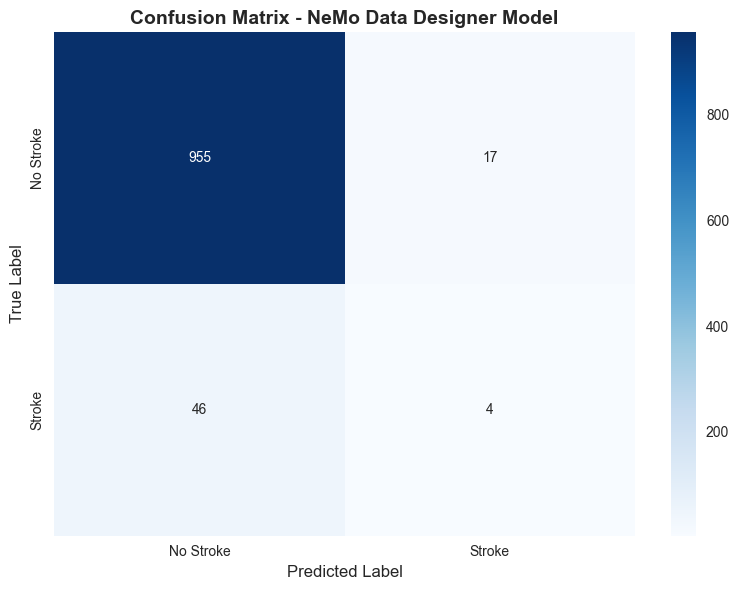

In [58]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - NeMo Data Designer Model', fontsize=14, fontweight='bold')
ax.set_xticklabels(['No Stroke', 'Stroke'])
ax.set_yticklabels(['No Stroke', 'Stroke'])
plt.tight_layout()
plt.show()

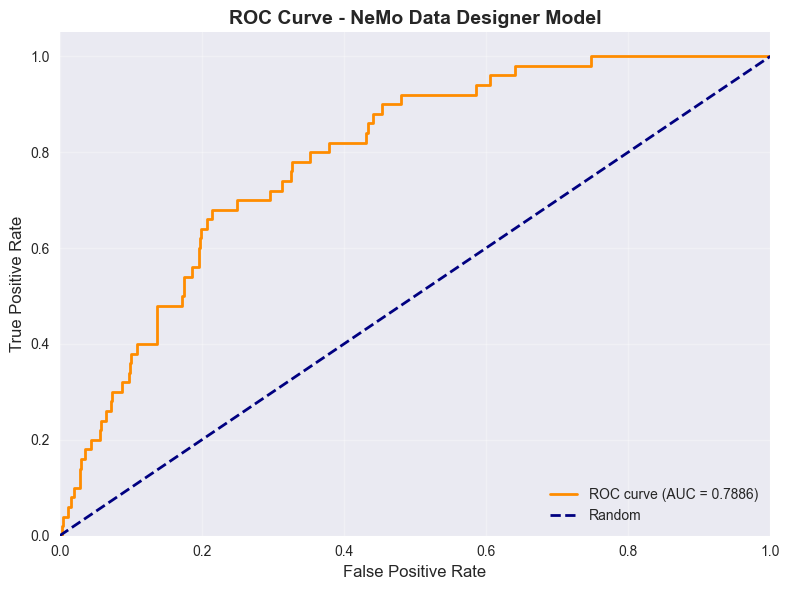

In [59]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - NeMo Data Designer Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

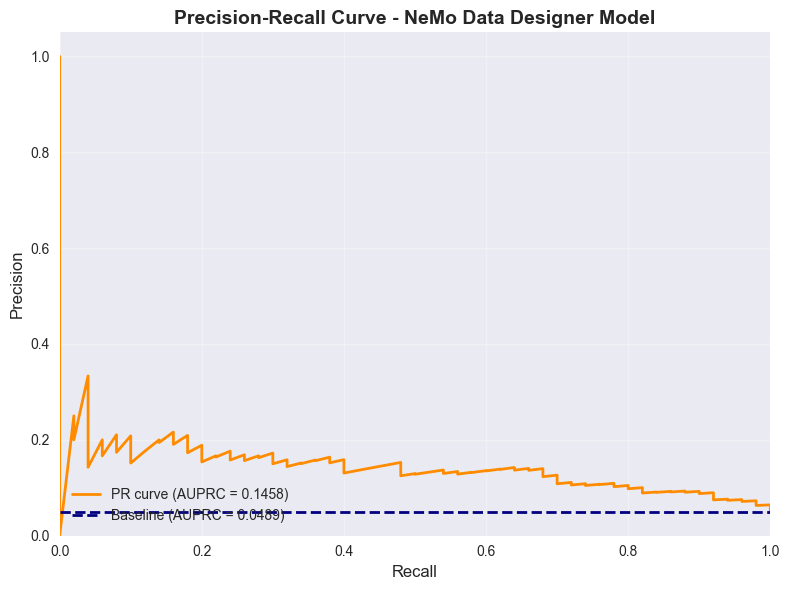

In [60]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, color='darkorange', lw=2, 
         label=f'PR curve (AUPRC = {pr_auc:.4f})')

baseline = y_test.mean()
plt.axhline(y=baseline, color='navy', lw=2, linestyle='--', 
           label=f'Baseline (AUPRC = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - NeMo Data Designer Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

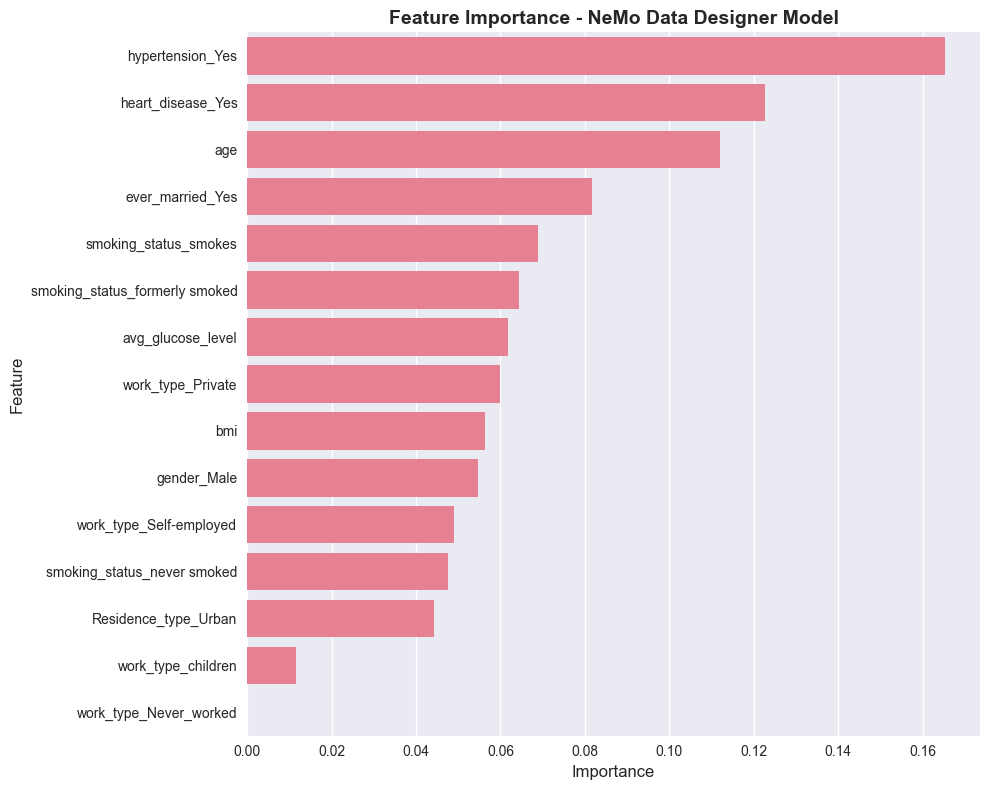


Top 5 Most Important Features:
                  feature  importance
4        hypertension_Yes    0.165352
5       heart_disease_Yes    0.122639
0                     age    0.111922
6        ever_married_Yes    0.081665
14  smoking_status_smokes    0.068916


In [61]:
# Feature Importance
plt.figure(figsize=(10, 8))
feature_importance = ndd_model.feature_importances_
feature_names = X_train.columns  # X_train already has features only (no 'stroke' column)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance - NeMo Data Designer Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance_df.head())

### Model Summary


In [62]:
print("=" * 70)
print("NeMo Data Designer Model - Complete Summary")
print("=" * 70)
print(f"\n📊 Dataset Information:")
print(f"   Original samples:  {len(df_original):,}")
print(f"   Synthetic samples: {len(processed_synthetic):,} (filtered by plausibility ≥7)")
print(f"   Features:          {X_train.shape[1]}")

print(f"\n🎯 Class Distribution:")
print(f"   Original: {df_original['stroke'].mean()*100:.2f}% stroke")
print(f"   Training (augmented): {y_train.mean()*100:.2f}% stroke ({len(y_train):,} samples)")
print(f"   Testing (original): {y_test.mean()*100:.2f}% stroke ({len(y_test):,} samples)")
print(f"   Training improvement: {y_train.mean()/df_original['stroke'].mean():.2f}x")

print(f"\n🔬 Train/Test Split:")
print(f"   Training:  {len(X_train):,} samples (original + synthetic)")
print(f"   Testing:   {len(X_test):,} samples (SAME as other models - no synthetic)")

print(f"\n📈 Performance Metrics:")
print(f"   PR-AUC (PRIMARY):  {pr_auc:.4f}")
print(f"   Baseline PR-AUC:   {y_test.mean():.4f}")
print(f"   Lift over baseline: {pr_auc/y_test.mean():.2f}x")
print(f"   ---")
print(f"   ROC-AUC:           {roc_auc:.4f}")
print(f"   Accuracy:          {accuracy:.4f}")
print(f"   Precision:         {precision:.4f}")
print(f"   Recall:            {recall:.4f}")
print(f"   F1-Score:          {f1:.4f}")

print(f"\n💰 Generation Cost Estimate:")
print(f"   Samples generated: 249 (3 batches of 100, 100, 49)")
print(f"   Samples after filtering (≥7): {len(processed_synthetic)}")
print(f"   With LLM validation: Yes (plausibility scores)")
print(f"   Model used: {model_alias}")
print(f"   Estimated cost: ~$0.50-2.00")

print(f"\n⏱️  Generation Time:")
print(f"   Total time: ~11 minutes (3 batches)")

print("\n" + "=" * 70)

NeMo Data Designer Model - Complete Summary

📊 Dataset Information:
   Original samples:  5,110
   Synthetic samples: 87 (filtered by plausibility ≥7)
   Features:          15

🎯 Class Distribution:
   Original: 4.87% stroke
   Training (augmented): 6.85% stroke (4,175 samples)
   Testing (original): 4.89% stroke (1,022 samples)
   Training improvement: 1.41x

🔬 Train/Test Split:
   Training:  4,175 samples (original + synthetic)
   Testing:   1,022 samples (SAME as other models - no synthetic)

📈 Performance Metrics:
   PR-AUC (PRIMARY):  0.1458
   Baseline PR-AUC:   0.0489
   Lift over baseline: 2.98x
   ---
   ROC-AUC:           0.7886
   Accuracy:          0.9384
   Precision:         0.1905
   Recall:            0.0800
   F1-Score:          0.1127

💰 Generation Cost Estimate:
   Samples generated: 249 (3 batches of 100, 100, 49)
   Samples after filtering (≥7): 87
   With LLM validation: Yes (plausibility scores)
   Model used: nemotron-super
   Estimated cost: ~$0.50-2.00

⏱️  Ge

## 14. Compare with Other Techniques

Compare NDD results with Base Model, Scale Pos Weight, and SMOTE approaches


In [ ]:
# Create a comparison dataframe
# Fill in your actual values from other notebooks

comparison_df = pd.DataFrame({
    'Technique': [
        'Base Model',
        'Scale Pos Weight',
        'SMOTE',
        'NeMo Data Designer'
    ],
    'Accuracy': [
        0.0,  # Fill in from base-model.ipynb
        0.0,  # Fill in from scale-pos-weight-model.ipynb
        0.0,  # Fill in from smote-model.ipynb
        0.0,  # Will be filled after running NDD model
    ],
    'Precision': [
        0.0,  # Fill in from base-model.ipynb
        0.0,  # Fill in from scale-pos-weight-model.ipynb
        0.0,  # Fill in from smote-model.ipynb
        0.0,  # Will be filled after running NDD model
    ],
    'Recall': [
        0.0,  # Fill in from base-model.ipynb
        0.0,  # Fill in from scale-pos-weight-model.ipynb
        0.0,  # Fill in from smote-model.ipynb
        0.0,  # Will be filled after running NDD model
    ],
    'F1 Score': [
        0.0,  # Fill in from base-model.ipynb
        0.0,  # Fill in from scale-pos-weight-model.ipynb
        0.0,  # Fill in from smote-model.ipynb
        0.0,  # Will be filled after running NDD model
    ],
    'ROC-AUC': [
        0.0,  # Fill in from base-model.ipynb
        0.0,  # Fill in from scale-pos-weight-model.ipynb
        0.0,  # Fill in from smote-model.ipynb
        0.0,  # Will be filled after running NDD model
    ],
    'PR-AUC': [
        0.0,  # Fill in from base-model.ipynb
        0.0,  # Fill in from scale-pos-weight-model.ipynb
        0.0,  # Fill in from smote-model.ipynb
        0.0,  # Will be filled after running NDD model
    ],
})

# After running NDD model, update the last row with your actual metrics:
# comparison_df.loc[3, 'Accuracy'] = accuracy
# comparison_df.loc[3, 'Precision'] = precision
# comparison_df.loc[3, 'Recall'] = recall
# comparison_df.loc[3, 'F1 Score'] = f1
# comparison_df.loc[3, 'ROC-AUC'] = roc_auc
# comparison_df.loc[3, 'PR-AUC'] = pr_auc

print("\n" + "=" * 80)
print("Performance Comparison Across All Techniques")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)
print("\n⚠️ Fill in actual values from your other notebooks after running all models")


In [ ]:
# Visual comparison of metrics (uncomment after filling in comparison_df with actual values)

# fig, axes = plt.subplots(2, 3, figsize=(16, 10))
# axes = axes.ravel()

# metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'PR-AUC']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# for idx, metric in enumerate(metrics):
#     ax = axes[idx]
#     bars = ax.bar(comparison_df['Technique'], comparison_df[metric], color=colors)
#     ax.set_title(metric, fontsize=12, fontweight='bold')
#     ax.set_ylabel('Score', fontsize=10)
#     ax.set_ylim(0, 1)
#     ax.tick_params(axis='x', rotation=45)
#     ax.grid(axis='y', alpha=0.3)
    
#     # Add value labels on bars
#     for bar in bars:
#         height = bar.get_height()
#         if height > 0:  # Only show if value is filled in
#             ax.text(bar.get_x() + bar.get_width()/2., height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)

# plt.tight_layout()
# plt.suptitle('Performance Comparison: All Class Imbalance Techniques', 
#              fontsize=14, fontweight='bold', y=1.02)
# plt.show()

print("⚠️ Uncomment after filling in comparison metrics")


## 15. Key Insights & Next Steps


In [ ]:
print("=" * 80)
print("WORKFLOW SUMMARY - NeMo Data Designer for Stroke Prediction")
print("=" * 80)

print("\n✅ What You've Done:")
print("   1. Loaded UNSCALED data for NDD (real ages, glucose, BMI)")
print("   2. Configured NDD samplers based on actual stroke patient distributions")
print("   3. Added LLM-based medical coherence validation with real values")
print("   4. Generated preview to verify configuration")
print("   5. Loaded fitted scaler to apply to synthetic data")
print("   6. Set up processing pipeline that scales synthetic samples")

print("\n🔄 To Complete the Experiment:")
print("   1. Uncomment Cell 25 to generate full synthetic dataset (~10-20 min)")
print("   2. Uncomment Cell 30 to process and SCALE the generated data")
print("   3. Uncomment Cell 32 to combine SCALED original + SCALED synthetic")
print("   4. Uncomment Cell 34 to train XGBoost model")
print("   5. Uncomment Cell 36 to evaluate and get metrics")
print("   6. Fill in comparison table with metrics from all models")
print("   7. Uncomment visualization cells to compare results")

print("\n💡 Expected Insights:")
print("   • NDD may perform similarly to SMOTE (possibly slightly worse)")
print("   • LLM coherence validation is NDD's unique advantage")
print("   • SMOTE is faster and more cost-effective for numerical data")
print("   • NDD would excel with text-based medical features (clinical notes)")

print("\n📊 Key Considerations:")
print("   • Time: 10-20 minutes for generation")
print("   • Cost: ~$0.50-2.00 in API credits")
print("   • Learning: Valuable experience with LLM-based synthetic data")
print("   • IMPORTANT: NDD uses unscaled data, then we scale synthetic samples")
print("     This allows LLM to evaluate real medical values (age=67, not 0.72)")

print("\n🎯 Recommendations:")
print("   • Use Conservative generation (249 samples) for initial testing")
print("   • Keep plausibility threshold at 7+ for quality")
print("   • Compare honestly with SMOTE - document when each is better")
print("   • Save this approach for future text-based medical projects")

print("\n" + "=" * 80)
print("✓ Notebook Ready! Uncomment cells as you progress through the workflow.")
print("=" * 80)
